# Spectral Differentiation using modified wavenumbers; A Pedagogical Example

In [1]:
import numpy as np
from findiff import FinDiff
import matplotlib.pyplot as plt 

### Set up data.

In [2]:
m=2                              #the order of finite difference approximation
Nx=65                            #the number of mesh points
x = np.linspace(0, 2*np.pi, Nx)  #this is our 1D mesh
phi = np.sin(x)                  #this is a variable on the mesh

Because the solution is periodic, we copy a stencil size of data for boundary conditions (these are commonly referred to as ghost or halo cells):

In [3]:
for i in range(m):
    x = np.append(x, x[i+1]+2*np.pi)
    phi = np.append(phi, phi[i+1])

for i in range(m):
    x = np.insert(x, 0, -x[2*i+1])
    phi = np.insert(phi, 0, -phi[2*i+1])

### Get 2nd order a finite difference approximation $\frac{\partial \phi}{\partial x}$

In [4]:
d_dx = FinDiff(0, x[1]-x[0], acc=m)
dphi_dx = d_dx(phi)

The exact solution is $\cos (\phi)$. Let's plot the finite difference approximation (not on the halo cells) and the exact solution to compare:

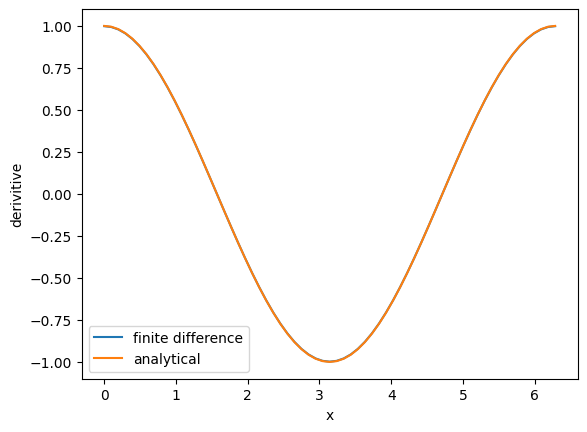

In [5]:
plt.plot(x[m:-m], dphi_dx[m:-m], label='finite difference')
plt.plot(x[m:-m], np.cos(x[m:-m]), label='analytical')
plt.xlabel('x')
plt.ylabel('derivitive')
plt.legend()

There are small differences due to the finite difference approximation. This can be seen clearer by plotting the difference between the finite difference approximation and the analytical:

Text(0.5, 0, 'x')

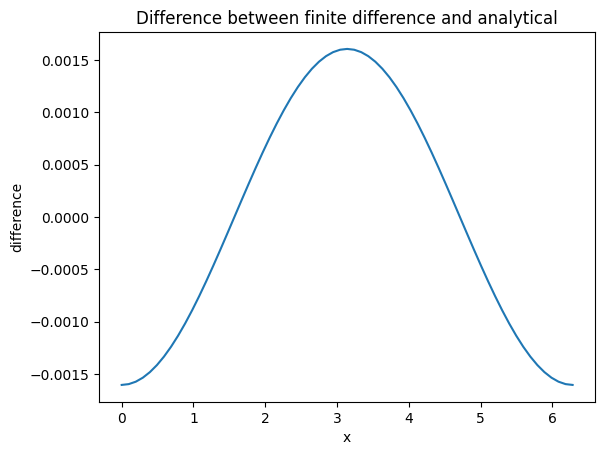

In [6]:
plt.plot( x[m:-m], dphi_dx[m:-m] - np.cos(x[m:-m]) )
plt.title('Difference between finite difference and analytical')
plt.ylabel('difference')
plt.xlabel('x')

# Spectral 

Let us now use a spectral representation to compute our derivative:

In [7]:
from scipy.fft import fft, ifft, fftshift

For FFTs, we need to pass the data in the domain [0, 2pi) (i.e., without halos, and without the last point which is repeated at 0 and 2pi). We strip x and phi, and store the data without halos in x2, phi2:

In [8]:
x2 = x[m:-m-1]
phi2 = phi[m:-m-1]

Now we can do the FFT, then compute the derivative in Fourier space:

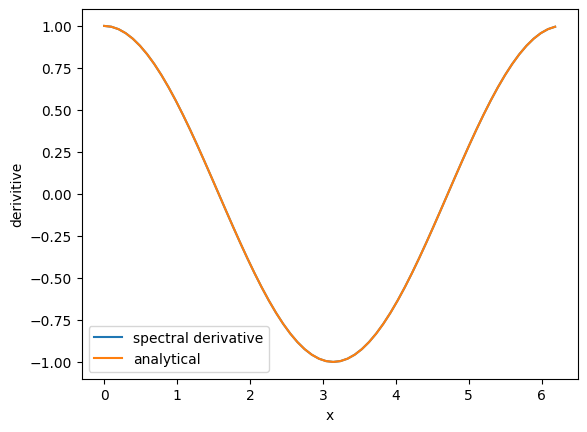

In [9]:
phi_hat = fft(phi2)
k = np.arange(Nx-1)-Nx//2
k=fftshift(k)
phi_hat *= complex(0,1)*k

plt.plot(x2, ifft(phi_hat).real, label='spectral derivative')
plt.plot(x2, np.cos(x2), label='analytical')

plt.xlabel('x')
plt.ylabel('derivitive')
plt.legend()

Plotting the difference between the spectral derivative and the analytical solution reveals the spectral method is highly accurate, as expected (note the scale is around machine precision):

Text(0.5, 0, 'x')

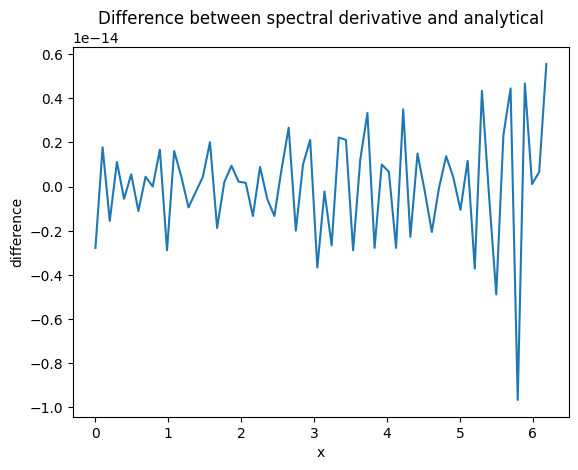

In [10]:
plt.plot(x2, ifft(phi_hat).real - np.cos(x2))
plt.title('Difference between spectral derivative and analytical')
plt.ylabel('difference')
plt.xlabel('x')

Although this is highly accurate, if using this in a finite difference solver (where the pressure is solved with a spectral method, but the other transport equations are solved with finite differences), there will be inconsistency in the discretisation, leading to issues in pressure-velocity coupling. What we need is for the FFT-based derivative to be equal to our finite difference one (not the analytical one). We can see that this is not the case, if we plot the difference between the finite difference approximation and the spectral approximation:

Text(0.5, 0, 'x')

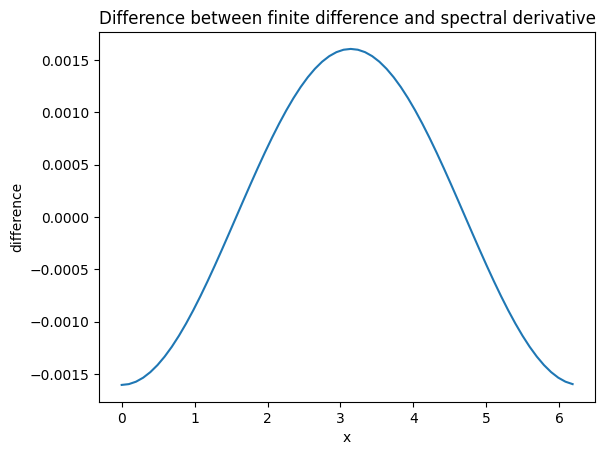

In [11]:
plt.plot( x2, dphi_dx[m:-m-1] - ifft(phi_hat).real)
plt.title('Difference between finite difference and spectral derivative')
plt.ylabel('difference')
plt.xlabel('x')

To fix this, we compute the modified wavenumbers:

In [12]:
dx = x[1]-x[0]
kp = np.zeros_like(k)
kp = np.sin(k*dx)/dx

Let's plot them:

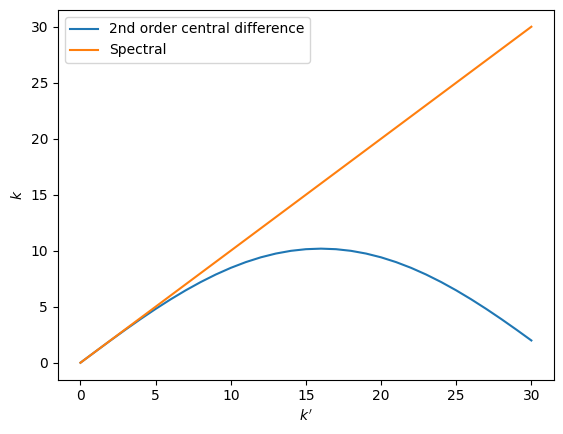

In [13]:
plt.plot(k[:Nx//2-1],kp[:Nx//2-1], label='2nd order central difference')
plt.plot(k[:Nx//2-1],k[:Nx//2-1], label='Spectral')
plt.ylabel('$k$')
plt.xlabel('$k^\prime$')
plt.legend()

We perform the spectral derivative using modified wavenumbers:

Text(0.5, 0, 'x')

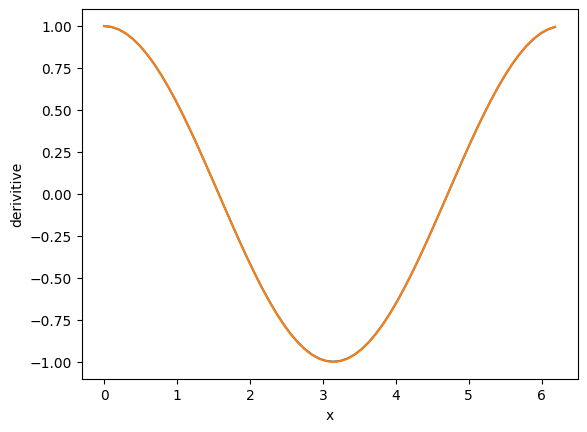

In [14]:
phi_hat = fft(phi2)
phi_hat *= complex(0, 1) * kp

plt.plot(x2, ifft(phi_hat).real)
plt.plot(x2, np.cos(x2))

plt.ylabel('derivitive')
plt.xlabel('x')

If we plot the difference between the finite difference approximation and the spectral one with modified wavenumbers, we can see they are the same (to within machine precision):

Text(0.5, 0, 'x')

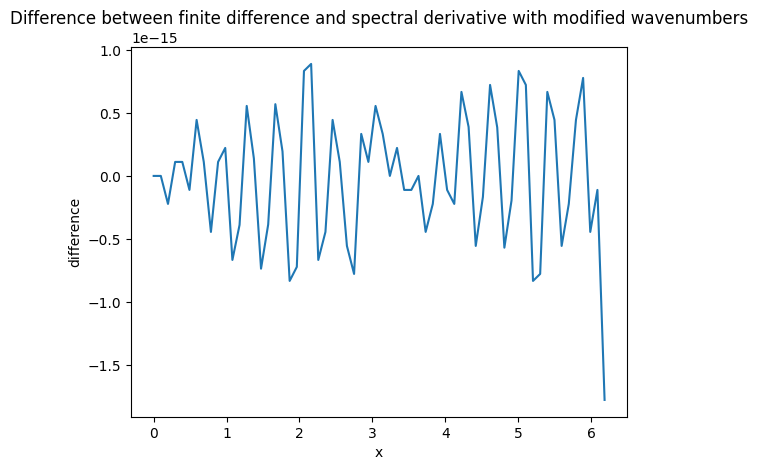

In [15]:
plt.plot( x2, dphi_dx[m:-m-1] - ifft(phi_hat).real)
plt.title('Difference between finite difference and spectral derivative with modified wavenumbers')
plt.ylabel('difference')
plt.xlabel('x')

# DCT / DST:

If we want to apply non-periodic boundary conditions, we need to use cosine/sine Fourier transforms (depending on boundary conditions). 

In [16]:
from scipy.fftpack import dct, dst

Our function is sin(x) (see box "Set up the data" above). This is defined on the interval [0, $2\pi$] (inclusive). We can see that sin(x) is odd about 0 and N-1; we therefore need a DST (for odd-odd functions). DST-I is close. However, the DST-I is odd about n=-1 and N. To give our input signal the correct boundary conditions for a DST-I, we therefore remove the first and last elements (as well as the halo cells);

In [17]:
phi2 = phi[m+1:-m-1]
x2 = x[m+1:-m-1]

Perform the differentiation in spectral space:

In [18]:
phi_hat = dst(phi2, type=1)
k = np.arange(len(x2))
phi_hat *= (k)/(len(x2)+1)

Now we need a DCT-I to perform the inverse (use a DCT since the derivative is even about the two boundaries). 

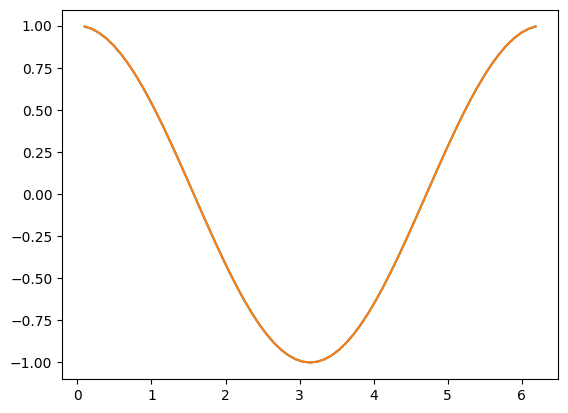

In [19]:
phi_hat = np.append(phi_hat, 0.)
phi_hat = np.insert(phi_hat, 0, 0.)

plt.plot(x2, dct(phi_hat, type=1)[1:-1]/2.)
plt.plot(x2, np.cos(x2))

Confirm this matches the analytical (but not the finite difference):

Text(0.5, 0, 'x')

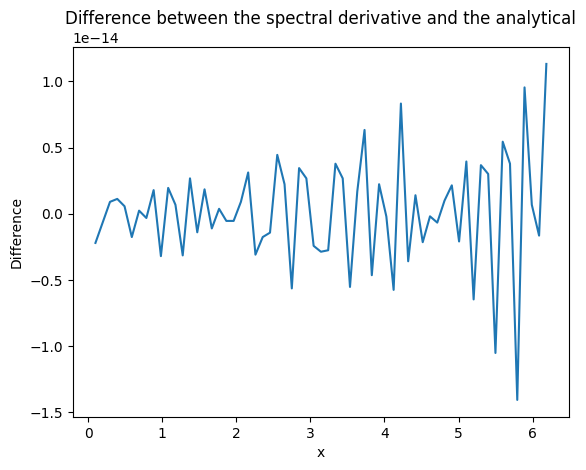

In [20]:
plt.plot(x2, dct(phi_hat, type=1)[1:-1]/2. - np.cos(x2))
plt.title('Difference between the spectral derivative and the analytical')
plt.ylabel('Difference')
plt.xlabel('x')

Text(0.5, 0, 'x')

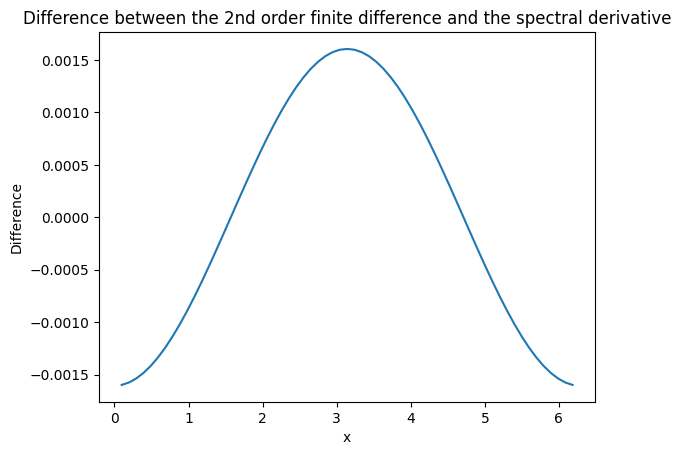

In [21]:
plt.plot( x2, dphi_dx[m+1:-m-1] - dct(phi_hat, type=1)[1:-1]/2.)
plt.title('Difference between the 2nd order finite difference and the spectral derivative')
plt.ylabel('Difference')
plt.xlabel('x')

Recompute the modified wavenumbers (same definition as above):

In [22]:
dx = x[1]-x[0]
k = np.arange(len(x2))
kp = np.zeros_like(k)
kp = np.sin((k)*dx)/dx

Perform the spectral differentiation with modified wavenumbers:

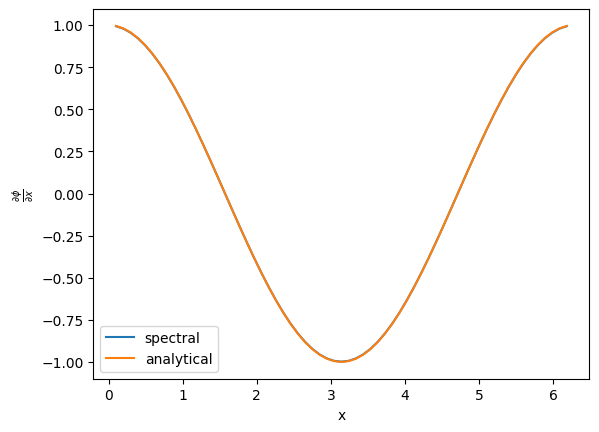

In [23]:
phi_hat = dst(phi2, type=1)
phi_hat *= (kp)/(len(x2)+1)

phi_hat = np.append(phi_hat, 0.)
phi_hat = np.insert(phi_hat, 0, 0.)

plt.plot(x2, dct(phi_hat, type=1)[1:-1]/2., label='spectral')
plt.plot(x2, np.cos(x2), label='analytical')
plt.ylabel(r'$\frac{\partial \phi}{\partial x}$')
plt.xlabel('x')
plt.legend()

Finally, confirm this is approximately the same as the finite difference approximation:

Text(0.5, 0, 'x')

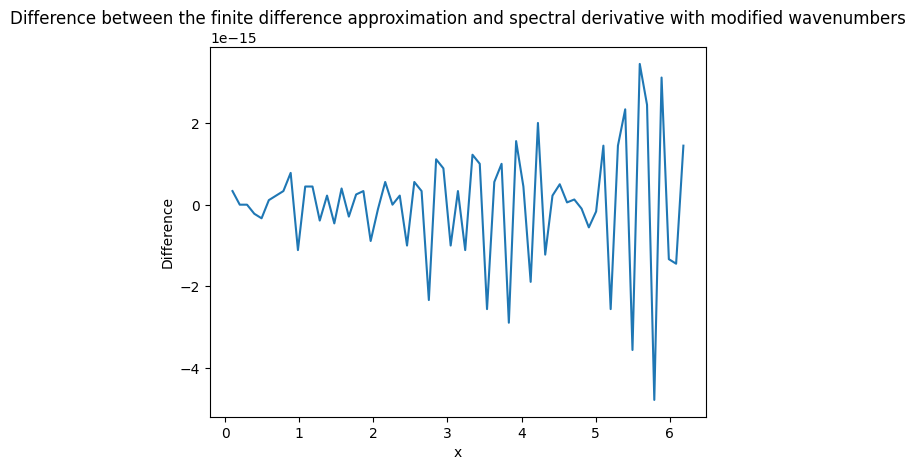

In [24]:
plt.plot( x2, dphi_dx[m+1:-m-1] - dct(phi_hat, type=1)[1:-1]/2.)
plt.title('Difference between the finite difference approximation and spectral derivative with modified wavenumbers')
plt.ylabel('Difference')
plt.xlabel('x')

# A proper test.

In [25]:
x=np.linspace(0,1,100)
phi = np.power(x,7)/7. - np.power(x,6)/2. + 17.*np.power(x,5)/25.-9.*np.power(x,4)/20.+274.*np.power(x,3)/1875.-12.*np.power(x,2)/625.

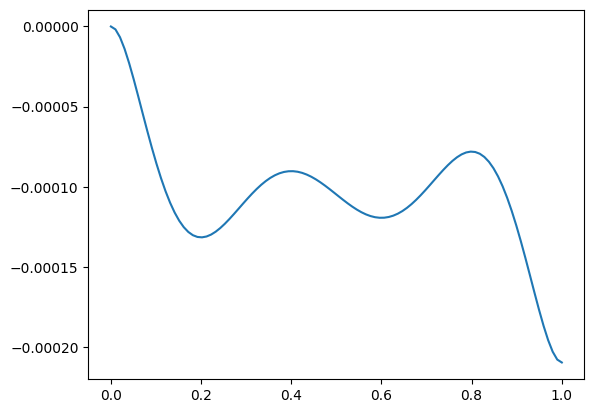

In [26]:
plt.plot(x,phi)

In [27]:
dphi_dx_exact = (x-1)*(x-4./5.)*(x-3./5.)*(x-2./5.)*(x-1./5.)*x

d_dx = FinDiff(0, x[1]-x[0], acc=2)
dphi_dx_2ndorder = d_dx(phi)

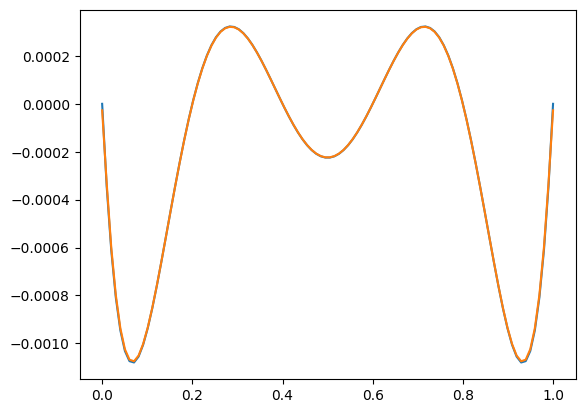

In [28]:
plt.plot(x,dphi_dx_exact)
plt.plot(x,dphi_dx_2ndorder)

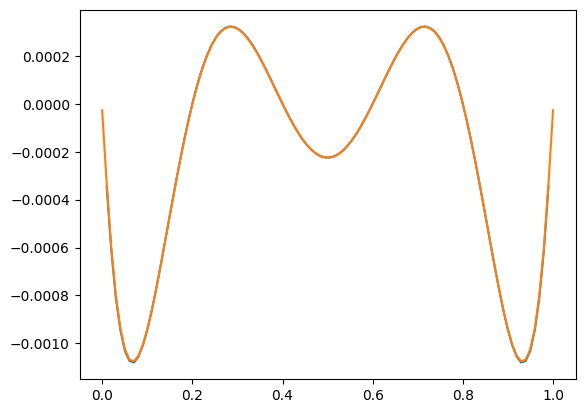

In [29]:
dx = x[1]-x[0]
k = np.arange(len(x))
kp = np.zeros_like(k)
kp = np.sin((k)*dx)/dx

phi_hat = dct(phi, type=1)
phi_hat *= (-kp)/(len(x)-1)

spectral_derivitive = dst(phi_hat[1:-1], type=1)*np.pi/2.

plt.plot(x[1:-1], spectral_derivitive )
plt.plot(x, dphi_dx_2ndorder)

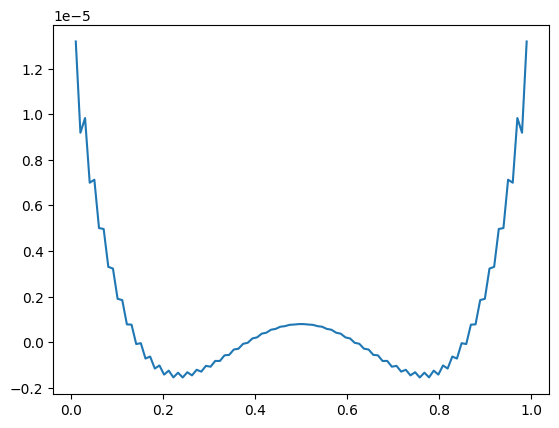

In [30]:
plt.plot(x[1:-1], dphi_dx_2ndorder[1:-1]-spectral_derivitive)